# Problem 1: Bias-Variance Decomposition

## Part 1:

Let $ y(x) = f(x) + \epsilon $, where $ \epsilon \sim \mathcal{N}(0, \sigma^2) $ is the noise. The model's prediction is $ \hat{y}(x) = g(x) $. The mean squared error (MSE) over test instances $ x_i $ is:

$$
MSE = \frac{1}{t} \sum_{i=1}^{t} \left( f(x_i) + \epsilon_i - g(x_i) \right)^2
$$

Expanding:

$$
MSE = \mathbb{E}\left[(f(x) + \epsilon - g(x))^2\right]
$$

This decomposes as:

$$
\mathbb{E}[\text{MSE}] = \underbrace{(\mathbb{E}[g(x)] - f(x))^2}_{\text{Bias}^2} + \underbrace{\mathbb{E}[(g(x) - \mathbb{E}[g(x)])^2]}_{\text{Variance}} + \underbrace{\mathbb{E}[\epsilon^2]}_{\text{Noise}}
$$

Thus:

$$
\mathbb{E}[\text{MSE}] = \text{Bias}^2 + \text{Variance} + \sigma^2
$$


## Part 2:

Given

$$
y(x) = x + \sin(1.5x) + \mathcal{N}(0, 0.3)
$$

Generate 20 points from y and display the dataset and f(x)

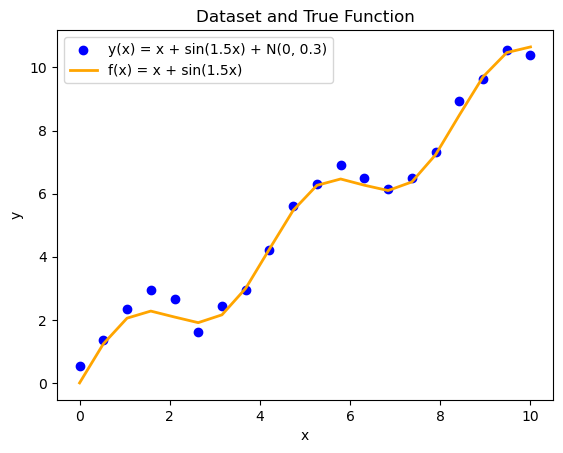

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Generate x values in the range [0, 10]
x = np.linspace(0, 10, 20)

# Generate y values with noise
y = x + np.sin(1.5 * x) + np.random.normal(0, 0.3, size=x.shape)

# Define the true function f(x)
f_x = x + np.sin(1.5 * x)

# Plot y(x) as a scatter plot and f(x) as a smooth line
plt.scatter(x, y, label="y(x) = x + sin(1.5x) + N(0, 0.3)", color='blue')
plt.plot(x, f_x, label="f(x) = x + sin(1.5x)", color='orange', linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Dataset and True Function")
plt.show()


## Part 3:

Use a weighted sum of polynomials as an estimator function for \( f(x) \). In particular, let the form of the estimator function be:

$$
g_n(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots + \beta_n x^n
$$

Consider three candidate estimators, \( g_1 \), \( g_3 \), and \( g_{10} \). Estimate the coefficients of each of the three estimators using the sampled dataset and plot \( y(x) \), \( f(x) \), \( g_1(x) \), \( g_3(x) \), and \( g_{10}(x) \). Which estimator is underfitting? Which one is overfitting?

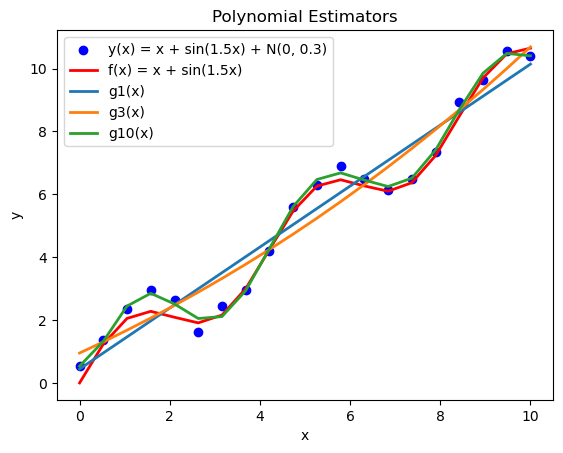

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degrees = [1, 3, 10]
np.random.seed(0)
x = np.linspace(0, 10, 20)
x = x[:, np.newaxis]
y = x + np.sin(1.5 * x) + np.random.normal(0, 0.3, size=x.shape)
f_x = x + np.sin(1.5 * x)

plt.scatter(x, y, label="y(x) = x + sin(1.5x) + N(0, 0.3)", color='blue')
plt.plot(x, f_x, label="f(x) = x + sin(1.5x)", color='red', linewidth=2)


for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    y_pred = model.predict(x[:])
    plt.plot(x, y_pred, label=f'g{degree}(x)', linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Polynomial Estimators")
plt.show()




The estimators g_1(x) and g_3(x) are severely underfitting the data, while g_10(x) is overfitting the data.

## Part 4: Bias-Variance Tradeoff


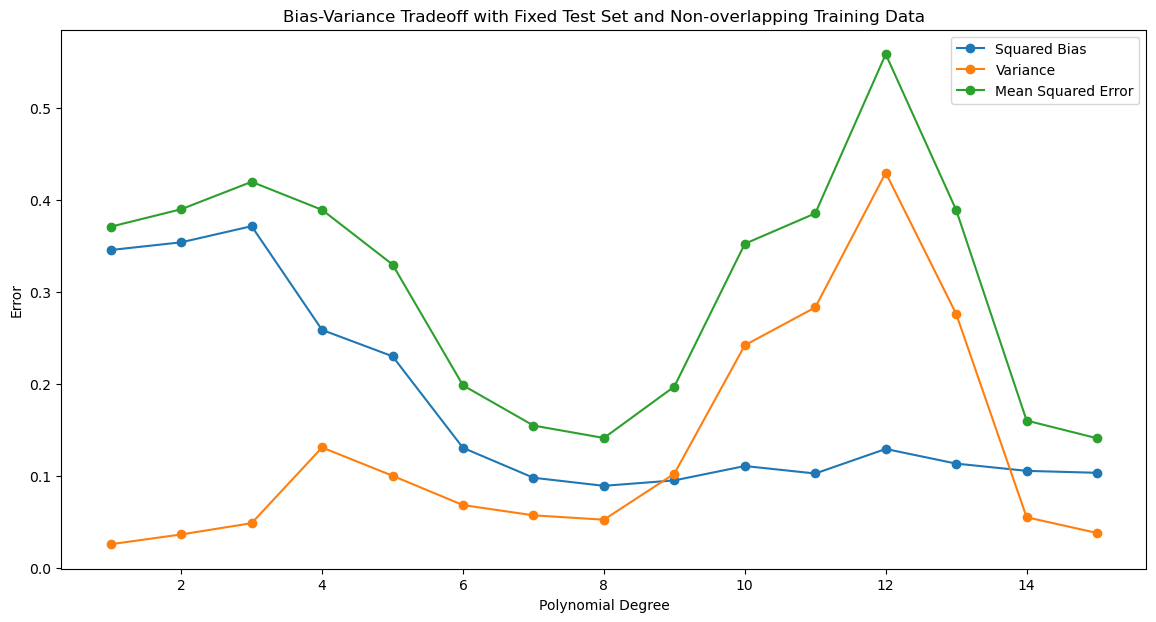

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Function to generate dataset excluding test samples
def generate_training_dataset(test_set=None, n_train_samples=40):
    x_all = np.linspace(0, 10, 1000)
    y_all = x_all + np.sin(1.5 * x_all) + np.random.normal(0, 0.3, size=x_all.shape)
    
    if test_set is not None:
        mask = np.isin(x_all, test_set.squeeze(), invert=True)
        x_train_pool = x_all[mask]  
        y_train_pool = y_all[mask]  
    else:
        x_train_pool = x_all
        y_train_pool = y_all

    # Randomly sample for training
    idx = np.random.choice(len(x_train_pool), n_train_samples, replace=False)
    return x_train_pool[idx][:, np.newaxis], y_train_pool[idx]  # Return as column vector for x

x_test, y_test = generate_training_dataset(None, n_train_samples=10)
np.random.seed(0)
n_datasets = 100
n_samples = 40
degrees = range(1, 16)

# Arrays to store results
mse_test = np.zeros((n_datasets, len(degrees)))
predictions = np.zeros((n_datasets, len(degrees), len(y_test)))


for i in range(n_datasets):
    x_train, y_train = generate_training_dataset(x_test, n_train_samples=n_samples)
    for j, degree in enumerate(degrees):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        
        predictions[i, j, :] = y_test_pred
        mse_test[i, j] = mean_squared_error(y_test, y_test_pred)

# Calculate mean and variance of predictions across datasets
mean_predictions = np.mean(predictions, axis=0)
variance_predictions = np.var(predictions, axis=0)
bias_squared = np.mean((mean_predictions - y_test) ** 2, axis=1)
mse_test_mean = np.mean(mse_test, axis=0)

plt.figure(figsize=(14, 7))
plt.plot(degrees, bias_squared, label='Squared Bias', marker='o')
plt.plot(degrees, variance_predictions.mean(axis=1), label='Variance', marker='o')
plt.plot(degrees, mse_test_mean, label='Mean Squared Error', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff with Fixed Test Set and Non-overlapping Training Data')
plt.legend()
plt.show()


The best model is at degree 8.

## Part 5: L2 Regularization


In [4]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


def generate_training_dataset(test_set=None, n_train_samples=40):
    x_all = np.linspace(0, 10, 1000)  # Generate a large pool of data points
    y_all = x_all + np.sin(1.5 * x_all) + np.random.normal(0, 0.3, size=x_all.shape)  # Corresponding y values
    
    
    if test_set is not None:
        mask = np.isin(x_all, test_set.squeeze(), invert=True)
        x_train_pool = x_all[mask]  # Exclude test samples from the x pool
        y_train_pool = y_all[mask]  
    else:
        x_train_pool = x_all
        y_train_pool = y_all

    # Randomly sample from the remaining points for train
    idx = np.random.choice(len(x_train_pool), n_train_samples, replace=False)
    return x_train_pool[idx][:, np.newaxis], y_train_pool[idx]

#fixed test set (size 10)
x_test, y_test = generate_training_dataset(None, n_train_samples=10)
degree = 10
alpha = 1.0 

n_datasets = 100  
n_samples = 40  

# Arrays to store results
mse_test_ridge = np.zeros(n_datasets)
predictions_ridge = np.zeros((n_datasets, len(y_test)))


for i in range(n_datasets):
    
    x_train, y_train = generate_training_dataset(x_test, n_train_samples=n_samples)
    
    #Ridge regression
    model_ridge = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model_ridge.fit(x_train, y_train)
    y_test_pred_ridge = model_ridge.predict(x_test)
    
    mse_test_ridge[i] = mean_squared_error(y_test, y_test_pred_ridge)
    predictions_ridge[i, :] = y_test_pred_ridge


mean_predictions_ridge = np.mean(predictions_ridge, axis=0)
variance_predictions_ridge = np.var(predictions_ridge, axis=0)
bias_squared_ridge = np.mean((mean_predictions_ridge - y_test) ** 2)
mse_test_mean_ridge = np.mean(mse_test_ridge)


print(f"Unregularized Model (Degree {degree}):")
print(f"  Squared Bias: {bias_squared[degree-1]:.4f}")
print(f"  Variance: {variance_predictions[degree-1].mean():.4f}")
print(f"  Mean Squared Error: {mse_test_mean[degree-1]:.4f}")

print(f"Regularized Model (Degree {degree}, Alpha {alpha}):")
print(f"  Squared Bias: {bias_squared_ridge:.4f}")
print(f"  Variance: {variance_predictions_ridge.mean():.4f}")
print(f"  Mean Squared Error: {mse_test_mean_ridge:.4f}")


Unregularized Model (Degree 10):
  Squared Bias: 0.1104
  Variance: 0.2418
  Mean Squared Error: 0.3522
Regularized Model (Degree 10, Alpha 1.0):
  Squared Bias: 0.2116
  Variance: 0.0381
  Mean Squared Error: 0.2497


/Users/bytedance/Documents/anaconda3/envs/COMS6998/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.74457e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/bytedance/Documents/anaconda3/envs/COMS6998/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.11292e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/bytedance/Documents/anaconda3/envs/COMS6998/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.37722e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/bytedance/Documents/anaconda3/envs/COMS6998/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.65029e-21): result may not be accurat

### Conclusion

**Bias:**
- **Unregularized Model:** Squared bias is 0.1104.
- **Regularized Model:** Squared bias is 0.2116.
- **Ans:** The regularized model has a higher bias, as expected, due to reduced model flexibility.

**Variance:**
- **Unregularized Model:** Variance is 0.2418.
- **Regularized Model:** Variance is 0.0381.
- **Ans:** The regularized model has much lower variance, which is expected as regularization reduces sensitivity to training data.

**Mean Squared Error (MSE):**
- **Unregularized Model:** MSE is 0.3522.
- **Regularized Model:** MSE is 0.2497.
- **Ans:** The regularized model has a lower MSE, indicating better overall performance.

**Answer:**
The regularized model has higher bias, but achieves much lower variance and MSE. This shows better generalization and makes it the better model.